# Bayesian Online Changepoint Detection
* It is a probabilistic model to identify the level shifts(mean-shifts) or variational shifts in incoming dataset
* It predicts posterior probability of run length(interval between to changepoints in dataset) so for a dataset of n-samples, there are n-possible run lengths.
* The model calculates probability that all those possible run lengths for each datapoint to be changepoints so it creates $NxN$ matrix where $N$ is length of the dataset
* So we set default threshold probability for it be a changepoint is $0.5$.

## Required Arguments to run the program:

* All of the algorithm related parameters are optional which has a default value given in the program itself.
* Description for each argument is given below :

* algo_kwargs={
            'data_col_index':1  -> column index from which metrics to be considered for anomaly detection ,
            'pthres':thres_prob -> probability after which a point is considered as changepoint,
            'Nw':samples_to_wait -> samples to wait before detecting changepoints,
            'mean_runlen':expected_run_length -> average run length between two change points in dataset
        }
        
* So the default value given are as follows:
     * algo_kwargs={
            'data_col_index':1,
            'pthres':0.5,
            'Nw':10,
            'mean_runlen':100
        }

## Dependencies :
* Download https://github.com/hildensia/bayesian_changepoint_detection this and run **python setup.py install** to install the bayesian changepoint detection module.
* Install **psycopg2** module using pip to connect to postgresql db
* Install **writefile_run** using pip , which is used to save the cell in a python file automatically

In [1]:
import writefile_run as writefile_run

In [2]:
filename = '../../anomaly_detectors/bayesian_detector/bayeschangept_wrapper.py'

In [3]:
%%writefile_run $filename

'''
importing all the required header files
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os


# Importing reader,and other dependencies python files as modules
from anomaly_detectors.reader_writer import db_properties as db_props
from anomaly_detectors.reader_writer import writer_configs as write_args


from anomaly_detectors.utils.preprocessors import *
from anomaly_detectors.utils.data_handler import *
from anomaly_detectors.utils.error_codes import error_codes
from anomaly_detectors.utils import type_checker as type_checker
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.utils import reader_helper
from anomaly_detectors.utils import make_ackg_json
from anomaly_detectors.bayesian_detector import bayesian_changept_detector

import json
import traceback
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

/home/rohithram/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
%%writefile_run $filename -a

'''
ideal argument types for algorithm
'''
algo_params_type ={
            'data_col_index':int,
            'pthres':float or int,
            'Nw':int,
            'mean_runlen':int,
            'to_plot':bool
        }

mode_options = ['detect only','detect and log','log only']

In [6]:
%%writefile_run $filename -a


def main(json_data,mode=mode_options[0],thres_prob=0.5,samples_to_wait=10,expected_run_length=100,to_plot=True):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in json string as input and parses json 
                            and gives list of dataframes, incase of any error it returns dictionary with error message
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *make_ack_json    - Function to make acknowledge json
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        
        Required Parameter:
            json_data: the Json object in the format of the input json given from reader api
        Optional Parameter:
            mode      : It's by default 'detect only' option, takes in mode_options which is in string format
            thres_prob (Type : Float , between 0 and 1) It is the probability threshold after which points are considered as change points
            Default: 0.5
            samples_to_wait: Positive Integer representing the no of samples after which the run length probability will be calculated. It is one of the algorithm related parameter
            Default: 10
            expected_run_length: positive Integer that is average run length or no of samples between two change-points. This originates from modeling the interval between change-points with exponential distribution
            Default : 100
            to_plot : Boolean .Give True to see the plots of change-points detected and False if there is no need for plotting
            Default : True
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        

        #algorithm arguments
        algo_kwargs={
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length,
            'to_plot':to_plot
        }
              
        '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
        '''
        error_codes1 = error_codes()
        
        try: 
            
            #converting user given mode to all lower case
            mode = mode.lower()
            # Check for mode
            if(mode not in mode_options):
                error_codes1['param']['data']['argument']='mode'
                error_codes1['param']['data']['value']=mode
                error_codes1['param']['message']='should be one of {}'.format((mode_options))
                return json.dumps(error_codes1['param'])
            
            
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=algo_params_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return json.dumps(res)
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            writer_data = []
            anomaly_detectors = []
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = pd.unique(data_per_asset['assetno'])[0]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])
                    print("Overview of data : \n{}\n".format(data_per_asset.head()))

                    for data_col in range(1,len(data_per_asset.columns[1:])+1):
                        algo_kwargs['data_col_index'] = data_col
                        print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,
                                                                                             data_per_asset.columns[data_col]))
                        
                        
                        anomaly_detector = bayesian_changept_detector.Bayesian_Changept_Detector(data_per_asset,
                                                                                                 assetno=assetno,
                                                                                                 **algo_kwargs)
                        data,anom_indexes = anomaly_detector.detect_anomalies()
                        
                            
                        sql_query_args = write_args.writer_kwargs
                        table_name = write_args.table_name
                        window_size = 10

                        anomaly_detectors.append(anomaly_detector)
                        
                
                
                ack_json = {}
                
                if(mode==mode_options[0] or mode==mode_options[1]):
                    ack_json = make_ackg_json.make_ack_json(anomaly_detectors)

                if(mode==mode_options[1] or mode==mode_options[2]):
                    '''
                    Instantiates writer class to write into local database with arguments given below
                    Used for Bulk writing
                    '''
                    writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                            table_name=table_name,window_size=window_size)

                    #called for mapping args before writing into db
                    res = writer.map_outputs_and_write()
                    if(res!=error_codes1['success']):
                        return json.dumps(res)
                
                #This case for only log mode, if writer is success , it returns success msg
                # Checking for ack_json to be empty or not
                if(bool(ack_json)==False):
                    ack_json['header'] = error_codes1['success']
                    
                return json.dumps(ack_json)
            elif(type(entire_data)==dict):
                return json.dumps(entire_data)
            else:
                '''
                Data empty error
                '''
                return json.dumps(error_codes1['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            
            error_codes1['unknown']['message']=str(e)
            return json.dumps(error_codes1['unknown'])

In [7]:
'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['TSFAD_A1']
con = '52.224.236.31:4242'
src_type =  'opentsdb'
param=['ec2_cpu_utilization_5f5533', 'rds_cpu_utilization_cc0c53']
from_timestamp=1392388200
to_timestamp=1393597320

In [8]:
reader_kwargs = lambda :{
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True}

algo_kwargs =lambda: {
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100,
            'to_plot':True
        }

In [9]:
'''
Dictionary of arguments given to wrapper fu`nction which executes this whole program for detecting changepoints and writing
to database
'''

reader_kwargs1 = reader_kwargs()
algo_kwargs1 = algo_kwargs()
json_data = reader_helper.read(reader_kwargs1)
res = main(**algo_kwargs1,json_data=json_data)
print(res)

http://52.224.236.31:4242/api/query?start=1392388200&end=1393597320&ms=true&m=max:none:ec2_cpu_utilization_5f5533{AssetNo=TSFAD_A1}
Data reader initialised 

{"code": "400", "status": "Bad Request", "message": "Expecting value: line 1 column 1 (char 0),(<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7fb7e2495588>)", "data": {}}


## Testing the algo on sample csv datasets

In [10]:
algo_kwargs()

{'expected_run_length': 100,
 'samples_to_wait': 10,
 'thres_prob': 0.5,
 'to_plot': True}


Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
                assetno       CO2   Methane
timestamp                                  
7808400000000  TSFAD_A1  0.090839 -1.170356
7808940000000  TSFAD_A1  0.028381 -1.340206
7809480000000  TSFAD_A1 -0.002849 -1.062837
7810020000000  TSFAD_A1 -0.002849 -0.811959
7810560000000  TSFAD_A1 -0.034078 -0.758978


Anomaly detection for AssetNo : TSFAD_A1 , Metric : CO2
 
Shape of the dataset : 
(296, 3)


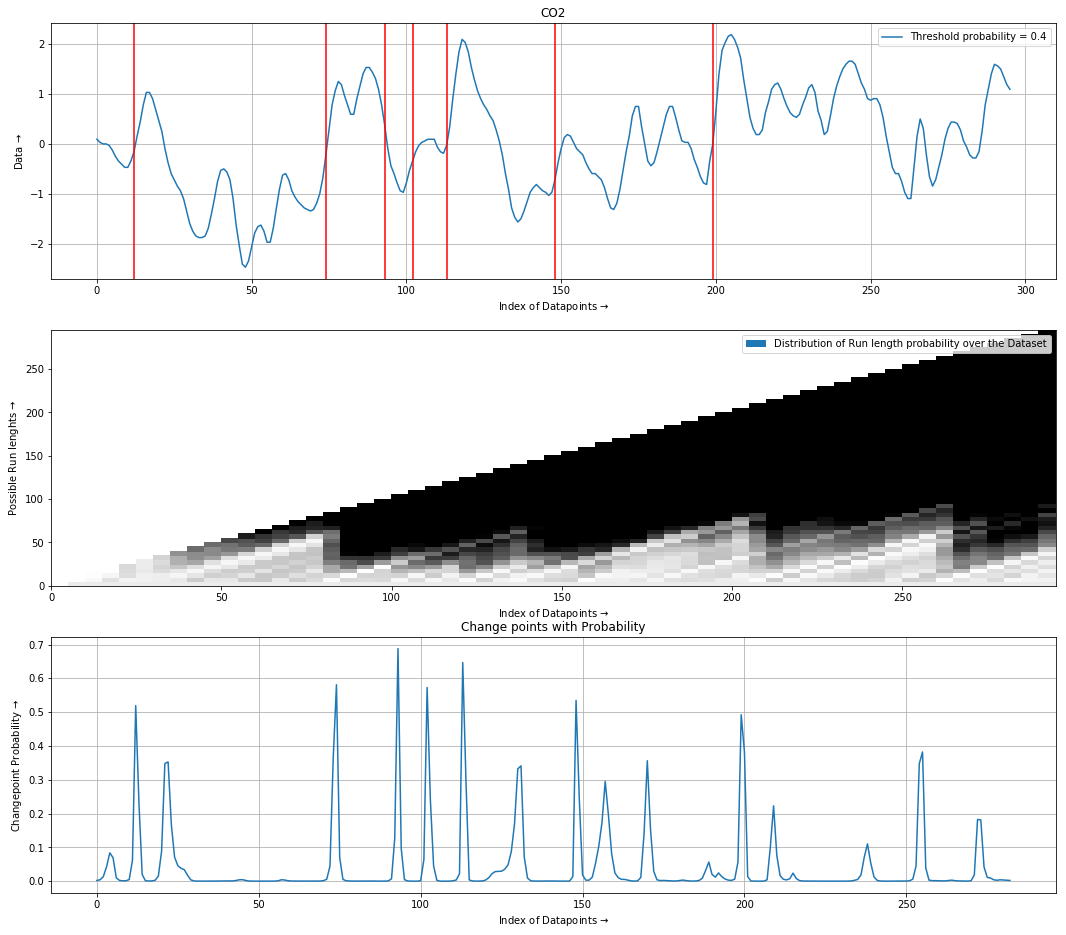


 No of Anomalies detected = 7

Anomaly detection for AssetNo : TSFAD_A1 , Metric : Methane
 
Shape of the dataset : 
(296, 3)


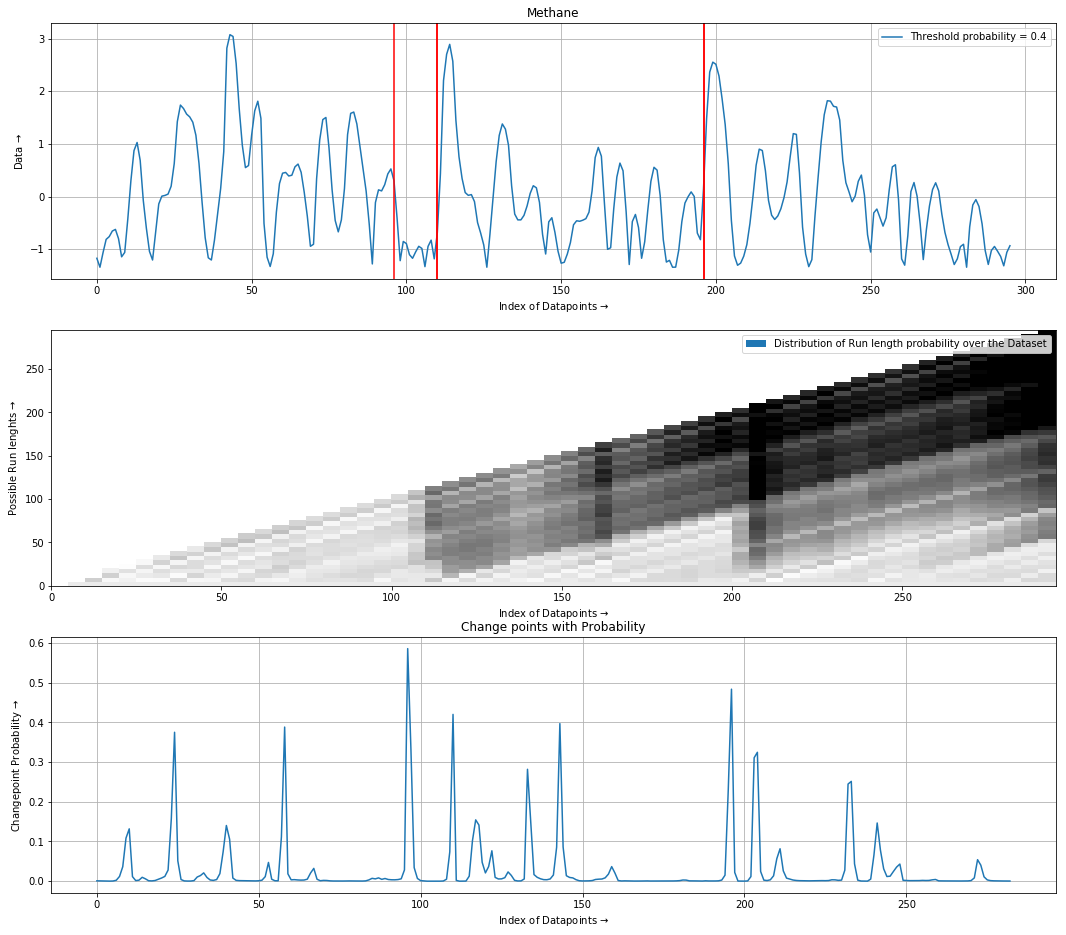


 No of Anomalies detected = 5
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "CO2", "datapoints": [{"from_timestamp": 7814880000000, "to_timestamp": 7814880000000, "anomaly_timestamp": [7814880000000], "anomaly_code": "bcp"}, {"from_timestamp": 7848360000000, "to_timestamp": 7848360000000, "anomaly_timestamp": [7848360000000], "anomaly_code": "bcp"}, {"from_timestamp": 7858620000000, "to_timestamp": 7858620000000, "anomaly_timestamp": [7858620000000], "anomaly_code": "bcp"}, {"from_timestamp": 7863480000000, "to_timestamp": 7863480000000, "anomaly_timestamp": [7863480000000], "anomaly_code": "bcp"}, {"from_timestamp": 7869420000000, "to_timestamp": 7869420000000, "anomaly_timestamp": [7869420000000], "anomaly_code": "bcp"}, {"from_timestamp": 7888320000000, "to_timestamp": 7888320000000, "anomaly_timestamp": [7888320000000], "anomaly_code": "bcp"}, {"from_timestamp": 7915860000000, "to_timestamp": 7915860000000, "anomaly_timestamp": [

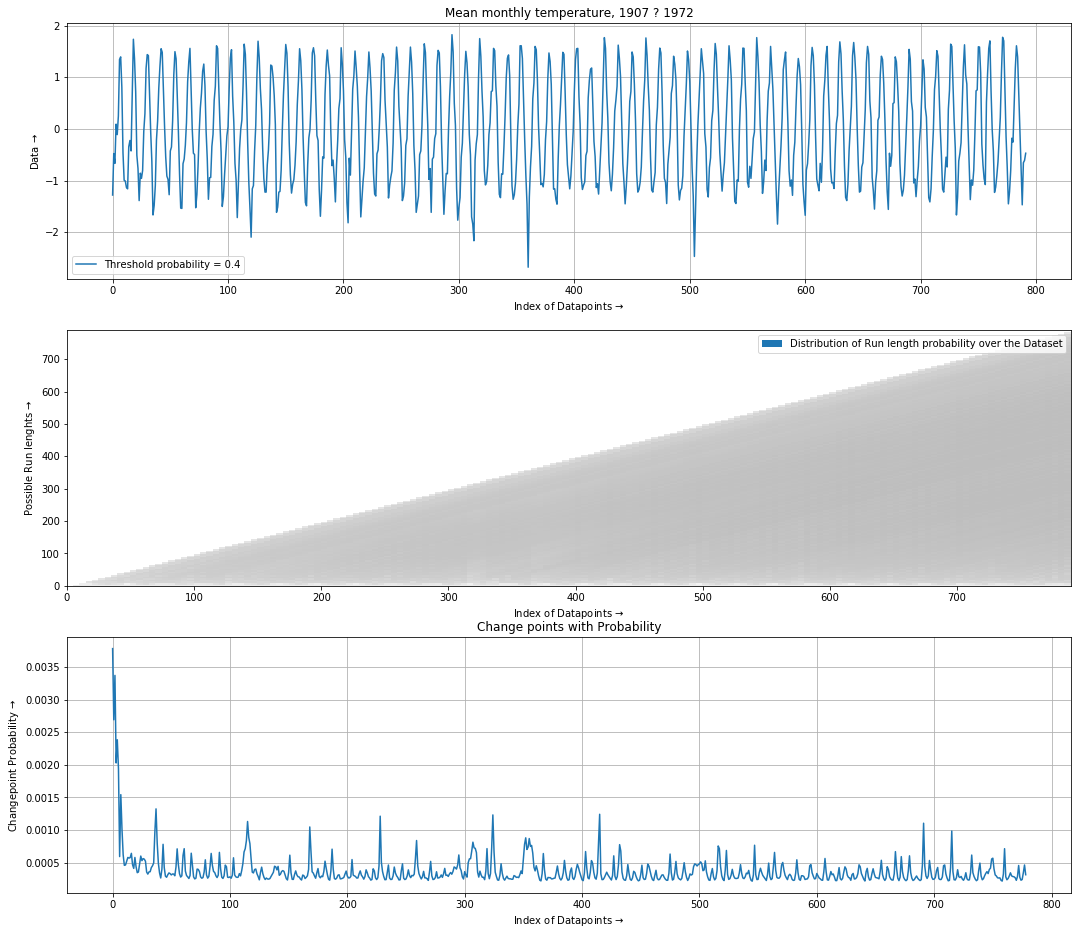


 No of Anomalies detected = 0
{"header": {"code": "200", "status": "OK", "message": "No Anomalies detected"}, "body": []}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
                assetno  \
timestamp                 
-694310400000  TSFAD_A1   
-691632000000  TSFAD_A1   
-689126400000  TSFAD_A1   
-686448000000  TSFAD_A1   
-683856000000  TSFAD_A1   

               Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981  
timestamp                                                                                      
-694310400000                                          -1.351533                               
-691632000000                                          -1.054180                               
-689126400000                                          -1.138722                               
-686448000000                                          -1

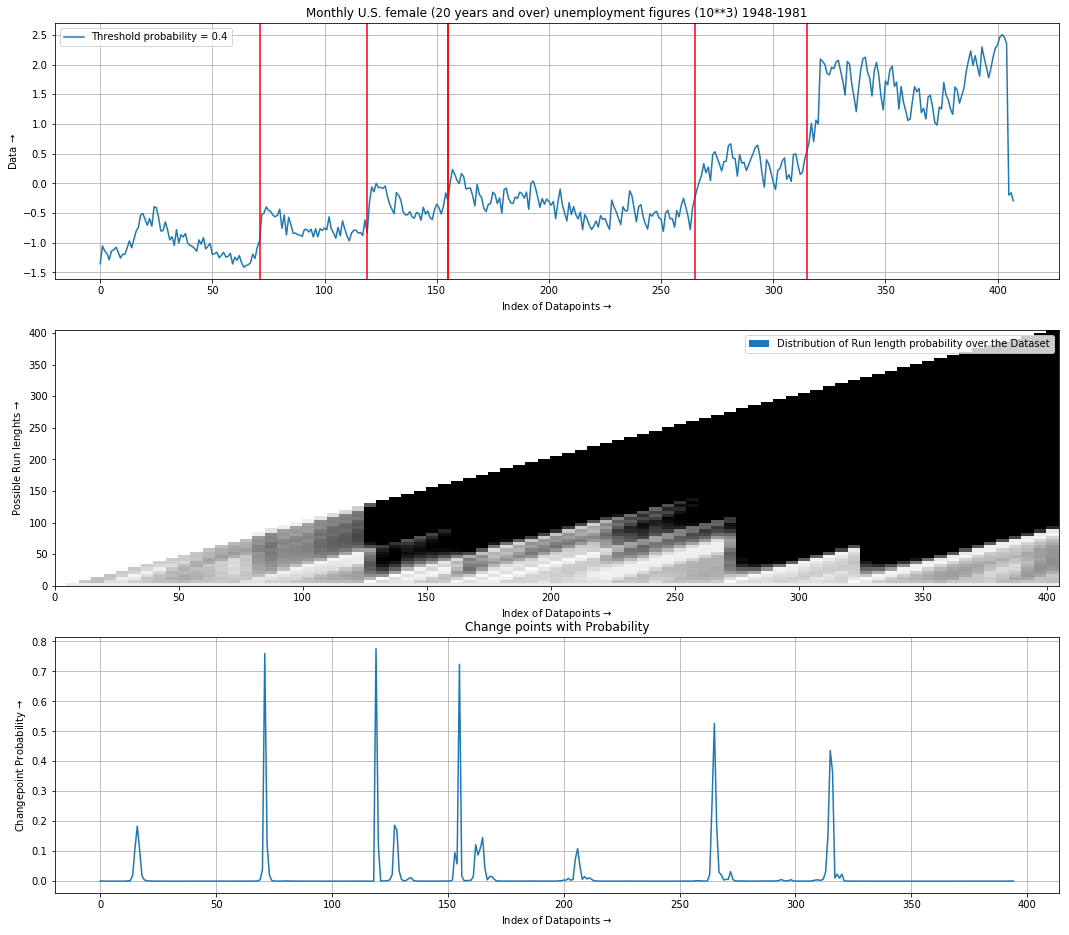


 No of Anomalies detected = 6
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981", "datapoints": [{"from_timestamp": -507600000000, "to_timestamp": -507600000000, "anomaly_timestamp": [-507600000000], "anomaly_code": "bcp"}, {"from_timestamp": -381369600000, "to_timestamp": -381369600000, "anomaly_timestamp": [-381369600000], "anomaly_code": "bcp"}, {"from_timestamp": -286675200000, "to_timestamp": -286675200000, "anomaly_timestamp": [-286675200000], "anomaly_code": "bcp"}, {"from_timestamp": -286675200000, "to_timestamp": -286675200000, "anomaly_timestamp": [-286675200000], "anomaly_code": "bcp"}, {"from_timestamp": 10368000000, "to_timestamp": 10368000000, "anomaly_timestamp": [10368000000], "anomaly_code": "bcp"}, {"from_timestamp": 141868800000, "to_timestamp": 141868800000, "anomaly_timestamp": [141868800000], "anomaly_code": "bcp"}]}]}]}

Detecting anoma

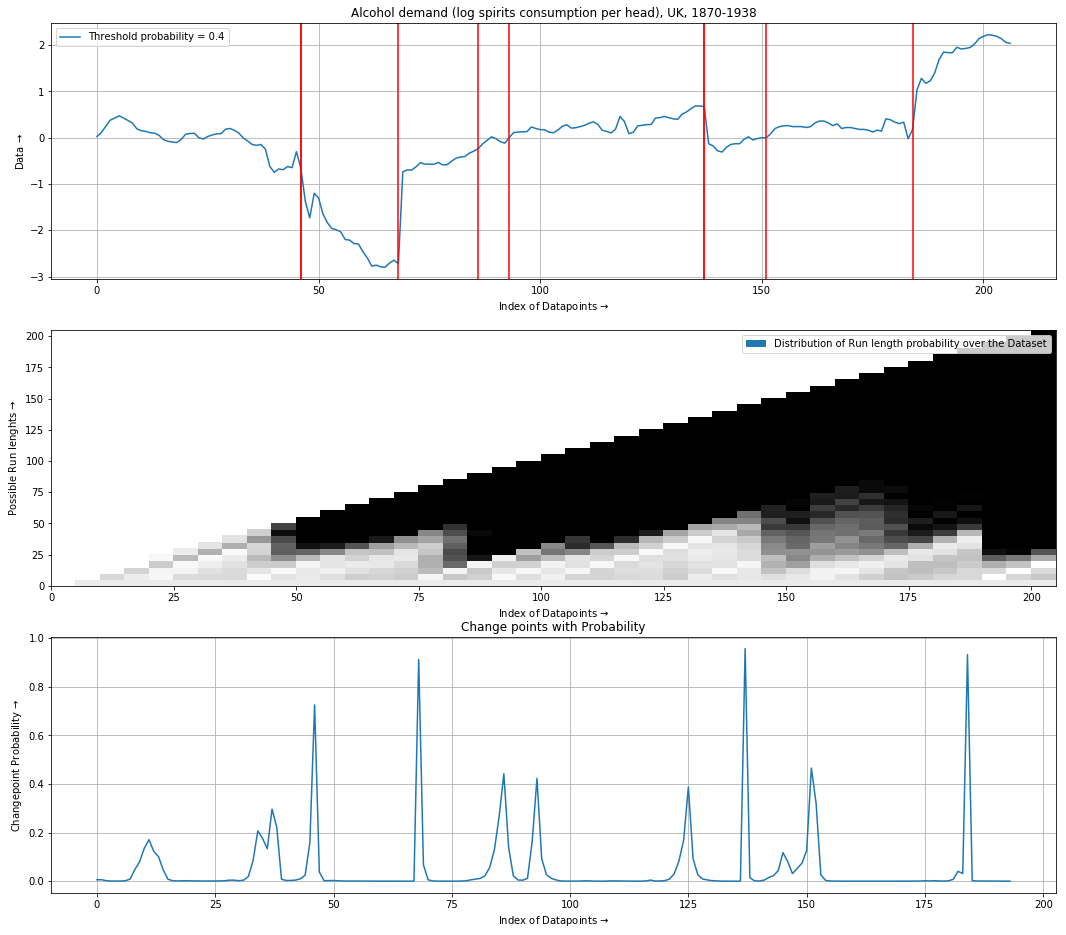


 No of Anomalies detected = 9
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "Alcohol demand (log spirits consumption per head), UK, 1870-1938", "datapoints": [{"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2432505600000, "to_timestamp": -2432505600000, "anomaly_timestamp": [-2432505600000], "anomaly_code": "bcp"}, {"from_timestamp": -2243203200000, "to_timestamp": -2243203200000, "anomaly_timestamp": [-2243203200000], "anomaly_code": "bcp"}, {"from_timestamp": -2169676800000, "to_timestamp": -2169676800000, "anomaly_timestamp": [-2169676800000], "anomaly_code": "bcp"}, {"from_timestamp": -1706832000000, "to_timestamp": -1706832000000, "anomaly_timestamp": [-1706832000000], "anomaly_code": "bcp"}, {"from_t

In [12]:
data_dir = '../../dataset/sample_csv_files/'
target_dir = '../../dataset/reader_csv_files/'
assetno = 'TSFAD_A1'
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    
    reader_kwargs1 = csv_helper.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno)
    
    json_data  = reader_helper.read(reader_kwargs1)
    algo_kwargs1 = algo_kwargs()
    algo_kwargs1['thres_prob'] = 0.4
    res = main(**algo_kwargs1,json_data=json_data)
    print(res)

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets